In [1]:
from tqdm import tqdm, TqdmSynchronisationWarning
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore", TqdmSynchronisationWarning)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [90]:
PATH = "data/caltech256_A3/"
os.listdir(PATH)

['test', 'valid', 'models', 'train', 'tmp']

In [4]:
air_animals = [
    "114.ibis-101",
    "100.hawksbill-101",
    "113.hummingbird",
    "049.cormorant",
    "060.duck",
    "089.goose",
    "118.iris", # hmmmmmm 
    "151.ostrich",
    "152.owl",
    "158.penguin",
    "207.swan",
]

land_animals = [
    "007.bat", # hmmmmm 
    "009.bear",
    "028.camel",
    "038.chimp",
    "056.dog",
    "064.elephant-101",
    "065.elk",
    "080.frog",
    "084.giraffe",
    "085.goat",
    "090.gorilla",
    "254.greyhound",
    "105.horse",
    "116.iguana",
    "121.kangaroo-101",
    "134.llama-101",
    "129.leopards-101",
    "164.porcupine",
    "168.raccoon",
    "186.skunk",
    "190.snake",
    "189.snail",
    "256.toad",
    "250.zebra"
]

water_animals = [
    "106.horseshoe-crab",
    "052.crab-101",
    "048.conch",
    "057.dolphin-101",
    "087.goldfish",
    "124.killer-whale",
    "148.mussels",
    "150.octopus",
    "201.starfish-101"
]

land_ss = land_animals[:9]
water_ss = water_animals[:9]
air_ss = air_animals[:9]

AIR = 1
LAND = 2
WATER = 3
CLASSES = [AIR, LAND, WATER]

sets = {
    "air": air_ss,
    "land": land_ss,
    "water": water_ss
}

sets

{'air': ['114.ibis-101',
  '100.hawksbill-101',
  '113.hummingbird',
  '049.cormorant',
  '060.duck',
  '089.goose',
  '118.iris',
  '151.ostrich',
  '152.owl'],
 'land': ['007.bat',
  '009.bear',
  '028.camel',
  '038.chimp',
  '056.dog',
  '064.elephant-101',
  '065.elk',
  '080.frog',
  '084.giraffe'],
 'water': ['106.horseshoe-crab',
  '052.crab-101',
  '048.conch',
  '057.dolphin-101',
  '087.goldfish',
  '124.killer-whale',
  '148.mussels',
  '150.octopus',
  '201.starfish-101']}

In [5]:
data_path = "data/256_ObjectCategories/"

In [6]:
orig_path = data_path
path = PATH

import shutil
# paths
orig = orig_path
val = f'{path}valid/'
train = f'{path}train/'
test = f'{path}test/'
folders = [train, val, test]

files = {
    "air": [],
    "land": [],
    "water": []
}
for cls in sets.keys(): # get list of files of each class
    for sub_cls in sets[cls]:
        for img in os.listdir(f"{orig}{sub_cls}"):
            files[cls].append(f"{orig}{sub_cls}/{img}")

for folder in folders: # delete existing splits
    shutil.rmtree(folder, ignore_errors=True)
            
for folder in folders: # train/val/test folder creation
    os.mkdir(f"{folder}")
    for cls in files.keys():
        os.mkdir(f"{folder}{cls}")
        
total = sum([len(files[key]) for key in files.keys()])
test_idxs = get_cv_idxs(total)
val_idxs = get_cv_idxs(total-len(test_idxs))

In [7]:
from pathlib import Path
files2 = {"old": [], "new": []}
for cls in files.keys():
    for img in files[cls]:
        files2["old"].append(img)
        parts = Path(img).parts
        new = [cls, parts[-1]]
        files2["new"].append(Path(*new))
        
files2 = pd.DataFrame(files2)

def make_new_path(old_path, idx):
    if idx in val_idxs:
        return f"{val}{old_path}"
    if idx in test_idxs:
        return f"{test}{old_path}"
    else:
        return f"{train}{old_path}"

files2["new_path"] = files2.apply(lambda row: make_new_path(row.new, row.name), axis=1)
files2.sample(5)

,old,new,new_path
2658,data/256_ObjectCategories/148.mussels/148_0106...,water/148_0106.jpg,data/caltech256_A3/train/water/148_0106.jpg
1297,data/256_ObjectCategories/038.chimp/038_0034.jpg,land/038_0034.jpg,data/caltech256_A3/train/land/038_0034.jpg
848,data/256_ObjectCategories/151.ostrich/151_0071...,air/151_0071.jpg,data/caltech256_A3/train/air/151_0071.jpg
1008,data/256_ObjectCategories/007.bat/007_0068.jpg,land/007_0068.jpg,data/caltech256_A3/train/land/007_0068.jpg
79,data/256_ObjectCategories/114.ibis-101/114_006...,air/114_0064.jpg,data/caltech256_A3/train/air/114_0064.jpg


In [8]:
for src, dst in zip(files2["old"], files2["new_path"]):
    try:
        shutil.copyfile(src, dst)
    except IsADirectoryError:
        pass

In [9]:
display(
    len(os.listdir(f"{path}train/water")),
    len(os.listdir(f"{path}test/water")),
    len(os.listdir(f"{path}valid/water"))
)

695

167

69

In [10]:
os.listdir(f"{PATH}test")

['water', 'air', 'land']

In [11]:
arch=resnet34
bs = 128
sz = 224
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(f'{PATH}', bs=bs, tfms=tfms)

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

/home/paperspace/fastai/courses/dl1/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/paperspace/fastai/courses/dl1/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [13]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                
    0      1.275003   29.131096  0.91048   



In [16]:
learn.fit(1e-1, 4)

epoch      trn_loss   val_loss   accuracy                 
    0      0.454917   0.246592   0.930131  
    1      0.337951   0.309804   0.927948                 
    2      0.28972    0.203593   0.943231                 
    3      0.255094   0.187061   0.947598                 



[0.187060559030183, 0.9475982501517217]

In [17]:
learn.precompute = False
learn.unfreeze()

In [18]:
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                  
    0      0.173363   0.164058   0.951965  
    1      0.1468     0.135279   0.956332                  
    2      0.123677   0.131554   0.962882                  



[0.13155385201154318, 0.9628820929464815]

# Evaluation

In [19]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9737991266375546

In [48]:
prds = np.argmax(probs, axis=1)
prbs = probs[:,1]

[[202   2   1]
 [  4 180   0]
 [  1   4  64]]


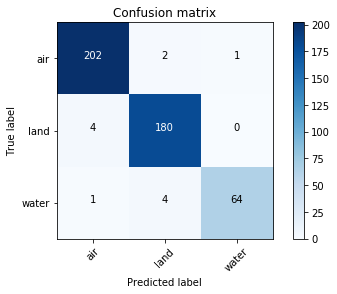

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, prds)
plot_confusion_matrix(cm, data.classes)

In [50]:
def get_label(preds):
    return data.classes[np.argmax(preds)]

# Plotting

In [20]:
from mpl_toolkits.mplot3d import Axes3D

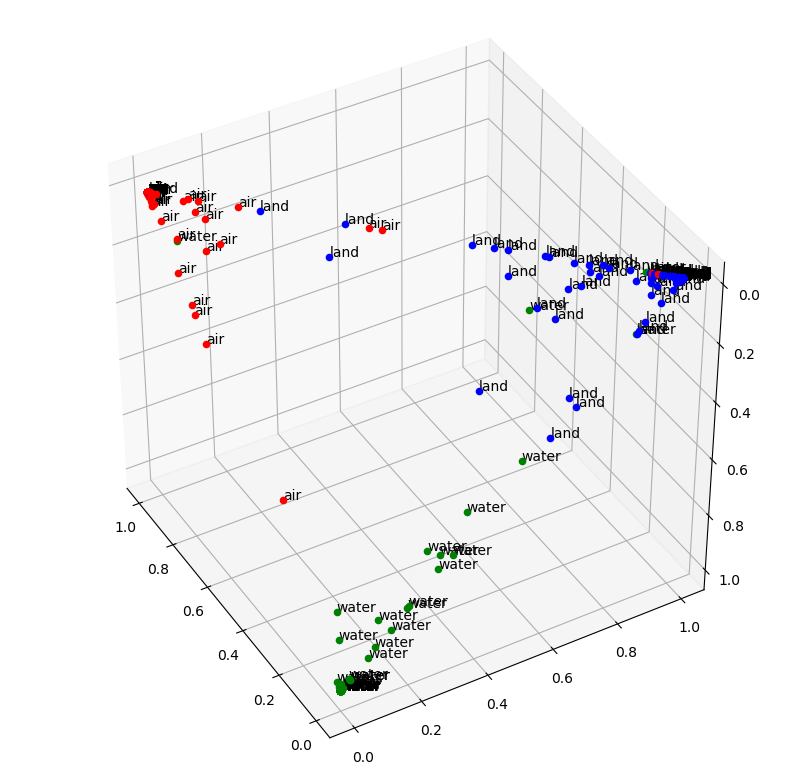

In [52]:
fig = plt.figure(num=None, figsize=(10, 10), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')

for prob, l in zip(probs, y):
    inference = prob.argmax(axis=0)
    label = 'air' if l==0 else 'land' if l==1 else 'water'
    ax.scatter(*prob, c='red' if l==0 else 'blue' if l==1 else 'green')
    ax.text3D(*prob, data.classes[l])
    
ax.view_init(-140, 30)

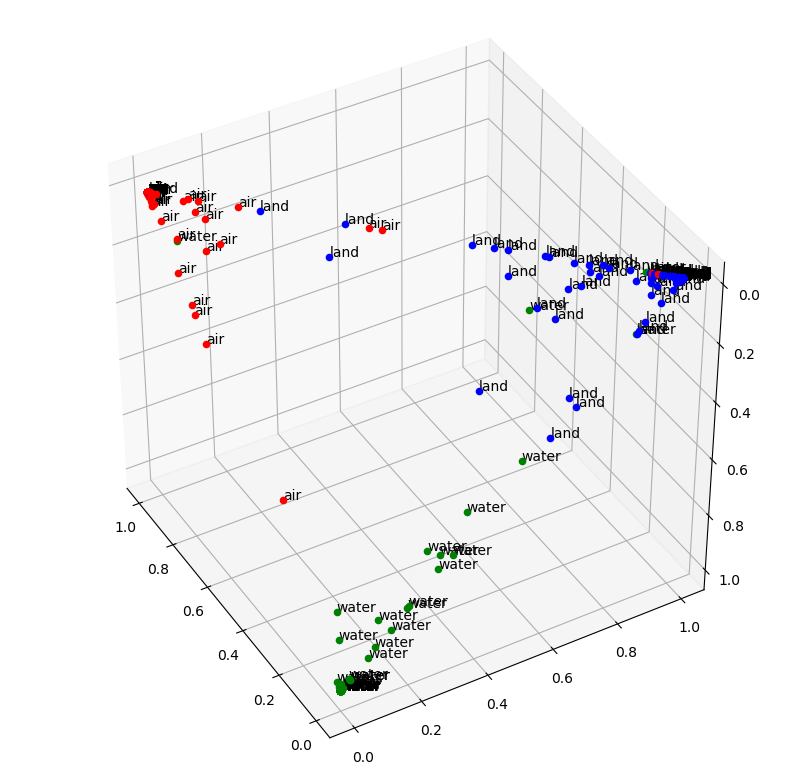

In [22]:
fig = plt.figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')

for prob, l in zip(probs, y):
    inference = prob.argmax(axis=0)
    ax.scatter(*prob, c='red' if l==0 else 'blue' if l==1 else 'green')
#     l = inference
    label = 'air' if l==0 else 'land' if l==1 else 'water'
    ax.text3D(*prob, label)
    
ax.view_init(-140, 30)

# Single Images

In [33]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

--2018-05-28 09:02:32--  https://3.bp.blogspot.com/_W90V87w3sr8/TP3ROrkGSwI/AAAAAAAAAXY/lk3AI0YvQYU/s1600/adelie_penguin_2.jpg
Resolving 3.bp.blogspot.com (3.bp.blogspot.com)... 172.217.12.129, 2607:f8b0:4006:800::2001
Connecting to 3.bp.blogspot.com (3.bp.blogspot.com)|172.217.12.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68622 (67K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  67.01K  --.-KB/s    in 0.02s   

2018-05-28 09:02:32 (3.00 MB/s) - ‘test.jpg’ saved [68622/68622]



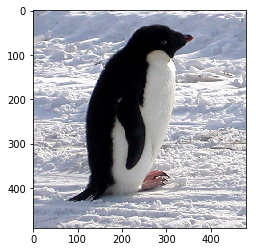

In [91]:
!wget -O test.jpg https://3.bp.blogspot.com/_W90V87w3sr8/TP3ROrkGSwI/AAAAAAAAAXY/lk3AI0YvQYU/s1600/adelie_penguin_2.jpg
img = plt.imread('test.jpg')
plt.imshow(img);

In [92]:
im = val_tfms(open_image("test.jpg"))

In [35]:
preds = learn.predict_array(im[None])

In [54]:
get_label(np.exp(preds))

'water'